# Download the Data

In [1]:
!pip3 install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

def get_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        class_name = image_name.split('_')[:-1]
        class_name = '_'.join(class_name)
        image_name = image_name + '.jpg'
        annotations[image_name] = class_name
    
    return annotations, i + 1

In [4]:
if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

In [5]:
train_annotations, _ = get_annotations('data/annotations/trainval.txt')
test_annotations, _ = get_annotations('data/annotations/test.txt')

In [6]:
all_annotations = {}

for key, value in train_annotations.items():
    all_annotations[key] = value
for key, value in test_annotations.items():
    all_annotations[key] = value

In [7]:
train_annotations = {}
test_annotations = {}

for key, value in all_annotations.items():
    if random.randint(0, 99) < 20:
        test_annotations[key] = value
    else:
        train_annotations[key] = value

In [8]:
train_count = len(list(train_annotations.keys()))
test_count = len(list(test_annotations.keys()))

print(train_count)
print(test_count)

5903
1446


# Visualize Data

In [9]:
classes = list(all_annotations.values())

classes = list(set(classes))

print(classes)
print('\nNum of classes:', len(classes))

['shiba_inu', 'keeshond', 'staffordshire_bull_terrier', 'saint_bernard', 'english_cocker_spaniel', 'great_pyrenees', 'Egyptian_Mau', 'samoyed', 'Maine_Coon', 'Bengal', 'american_bulldog', 'Ragdoll', 'yorkshire_terrier', 'basset_hound', 'Siamese', 'chihuahua', 'Persian', 'Abyssinian', 'german_shorthaired', 'British_Shorthair', 'beagle', 'japanese_chin', 'Birman', 'leonberger', 'Sphynx', 'miniature_pinscher', 'newfoundland', 'boxer', 'Russian_Blue', 'wheaten_terrier', 'pug', 'Bombay', 'havanese', 'scottish_terrier', 'english_setter', 'american_pit_bull_terrier', 'pomeranian']

Num of classes: 37


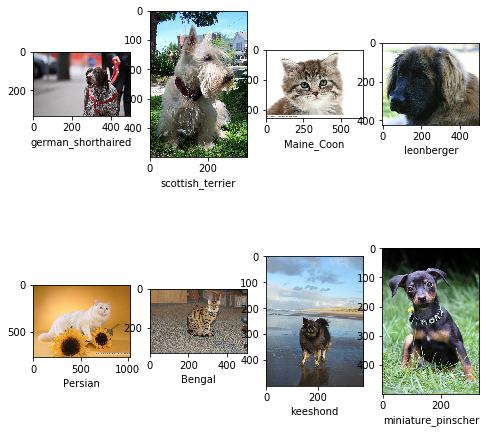

In [10]:
plt.figure(figsize=(8, 8))

train_images = list(train_annotations.keys())

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    image = train_images[random.randint(0, train_count - 1)]
    plt.imshow(plt.imread(os.path.join('data/images/', image)))
    plt.xlabel(train_annotations[image])
plt.show()

# SageMaker Setup

In [16]:
role = sagemaker.get_execution_role()
bucket_name = 'petsdata777'
training_image = get_image_uri(boto3.Session().region_name, 'image-classification',
                              repo_version='latest')
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:1


In [12]:
folders = ['train', 'train_lst', 'validation', 'validation_lst']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [13]:
def prepare_data(annotations, key='train'):
    images = list(annotations.keys())
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            shutil.copy(os.path.join('data/images/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    f.close()

In [14]:
prepare_data(train_annotations, 'train')

100%|██████████| 5903/5903 [00:18<00:00, 320.15it/s]


In [15]:
prepare_data(test_annotations, 'validation')

100%|██████████| 1446/1446 [00:05<00:00, 255.87it/s]


# Uploading Data to S3

In [17]:
sess = sagemaker.Session()
s3_train_path = sess.upload_data(path='train',bucket=bucket_name, 
                                 key_prefix='train')
print(1)
s3_train_lst_path = sess.upload_data(path='train_lst',bucket=bucket_name, 
                                     key_prefix='train_lst')
print(2)
s3_validation_path = sess.upload_data(path='validation',bucket=bucket_name,
                                      key_prefix='validation')
print(3)
s3_validation_lst_path = sess.upload_data(path='validation_lst',
                                          bucket=bucket_name, key_prefix='validation_lst')
print(4)


1
2
3
4


In [18]:
s3_validation_lst_path

's3://petsdata777/validation_lst'

# SageMaker Estimator

In [20]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    volume_size=100,
    max_run=36000,
    input_mode='File',
    output_path='s3://petsdata777/output',
    sagemaker_session=sess)

# Hyperparameters

In [22]:
model.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    image_shape='3,224,224',
    num_classes=37,
    mini_batch_size=32,
    resize=224,
    epochs=10,
    learning_rate=0.001,
    num_training_samples=train_count,
    augmentation_type='crop_color_transform'
    

)

# Data Channels

In [24]:
train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution="FullyReplicated",
                          content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_path, distribution="FullyReplicated",
                          content_type='application/x-image', s3_data_type='S3Prefix')

train_lst_data = sagemaker.inputs.TrainingInput(s3_train_lst_path, distribution="FullyReplicated",
                          content_type='application/x-image', s3_data_type='S3Prefix')
validation_lst_data = sagemaker.inputs.TrainingInput(s3_validation_lst_path, distribution="FullyReplicated",
                          content_type='application/x-image', s3_data_type='S3Prefix')


In [25]:
data_channels = {
    'train':train_data,
    'train_lst':train_lst_data,
    'validation':validation_data,
    'validation_lst':validation_lst_data
    
}

# Model Training

In [26]:
model.fit(inputs=data_channels, logs=True)

ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'ml.p3.2xlarge for training job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.

# Deploy Model

In [27]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed')

ValueError: Estimator is not associated with a training job

# Predictions

In [28]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))
          

1446


In [ ]:
deployed_model.content_type = 'image/jpeg'

In [30]:
index = 0

image_path = os.path.join(image_dir, images[index])

with open(image_path, 'rb') as f:
    b = bytearray(f.read())
result = deployed_model.predict(b)
result = json.loads(result)
print(result)

NameError: name 'deployed_model' is not defined

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)